In [1]:
import torch
import torch.nn as nn
import scipy.stats as stats
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchviz import make_dot


__toy data__


In [2]:
n = 1000

x = torch.concat([torch.tensor(stats.norm.rvs(loc=-1, scale=0.1, size=(n,1)), dtype=torch.float32), torch.tensor(stats.norm.rvs(loc=1, scale=0.1, size=(n,1)), dtype=torch.float32)])
#y = torch.concat([torch.zeros(n//2), torch.ones(n//2), torch.zeros(n//2), torch.ones(n//2)])
#c = torch.concat([torch.zeros(n//2), torch.ones(n//2), torch.zeros(n//2), torch.ones(n//2)])

y = torch.concat([-torch.ones(n), torch.ones(n)])
c = torch.concat([torch.ones(2*n)])

X = torch.stack(torch.unbind(x,dim=0))
Y = torch.stack(torch.unbind(y,dim=0)).unsqueeze(1)
C = torch.stack(torch.unbind(c,dim=0)).unsqueeze(1)

print(X)


tensor([[-0.9689],
        [-1.1237],
        [-0.9792],
        ...,
        [ 0.9013],
        [ 1.0106],
        [ 0.8345]])


__Toy data valou__

In [16]:
n = 1000

x = torch.concat([torch.tensor(stats.norm.rvs(loc=-1, scale=1, size=(2*n,1)), dtype=torch.float32)])
#y = torch.concat([torch.zeros(n//2), torch.ones(n//2), torch.zeros(n//2), torch.ones(n//2)])
#c = torch.concat([torch.zeros(n//2), torch.ones(n//2), torch.zeros(n//2), torch.ones(n//2)])

c = torch.concat([-torch.ones(n), torch.ones(n)])

X = torch.stack(torch.unbind(x,dim=0))
C = torch.stack(torch.unbind(c,dim=0)).unsqueeze(1)
C = C[torch.randperm(C.size(0))]

Y = C*X
print(X)
print(C)
print(Y)



tensor([[ 1.9013],
        [-1.9479],
        [-1.7994],
        ...,
        [-0.7328],
        [-0.2680],
        [-0.9773]])
tensor([[-1.],
        [-1.],
        [ 1.],
        ...,
        [-1.],
        [ 1.],
        [ 1.]])
tensor([[-1.9013],
        [ 1.9479],
        [-1.7994],
        ...,
        [ 0.7328],
        [-0.2680],
        [-0.9773]])


In [17]:

class MyDataset(Dataset):
    def __init__(self, X, C, Y):
        self.X = X
        self.C = C
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.C[idx], self.Y[idx]

dataset = MyDataset(X, C, Y)

batch_size = 100  # Example batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

__ICNN__

In [18]:
class ICNNet(nn.Module):
    def __init__(self, input_size = 1, layer_sizes = [1,4,1], context_layer_sizes=[1,2,1]):
        super(ICNNet, self).__init__()
        self.n_layers = len(layer_sizes)

        self.layers_activation = nn.ModuleList([nn.Softplus() for _ in range(self.n_layers-1)])

        self.layers_z = nn.ModuleList([nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=False) for i in range(self.n_layers-1)]) #non zero entries in the matrix ?

        self.layers_zu = nn.ModuleList([nn.Sequential(nn.Linear(context_layer_sizes[i], layer_sizes[i]), nn.ReLU()) for i in range(self.n_layers-1)])

        self.layers_x = nn.ModuleList([nn.Linear(input_size, layer_sizes[i+1], bias=False) for i in range(self.n_layers-1)])

        self.layers_xu = nn.ModuleList([nn.Linear(context_layer_sizes[i], input_size) for i in range(self.n_layers-1)])

        self.layers_u = nn.ModuleList([nn.Linear(context_layer_sizes[i], layer_sizes[i+1]) for i in range(self.n_layers-1)])

        self.layers_v = nn.ModuleList([nn.Sequential(nn.Linear(context_layer_sizes[i], context_layer_sizes[i+1]), nn.ReLU()) for i in range(self.n_layers-1)])
        
        # for layer in self.layers_z:
        #     nn.init.ones_(layer.weight)
        #     layer.weight.data *= 1/layer.weight.shape[1]

        # for layer in self.layers_zu:
        #     nn.init.eye_(layer.weight)
        #     nn.init.zeros_(layer.bias)

        # for layer in self.layers_x:
        #     nn.init.zeros_(layer.weight)
        #     nn.init_ones_(layer.bias)
        
        # for layer in self.layers_xu:
        #     nn.init.zeros_(layer.weight)
         
        # for layer in self.layers_u:
        #     nn.init.eye_(layer.weight)
        
        # for layer in self.layers_v:
        #     nn.init.eye_(layer.weight)
            
    def forward(self, x, c):
        input = x
        z = torch.zeros_like(x)
        u = c
        for i in range(self.n_layers-1):
            if i == self.n_layers-2:
                z = self.layers_z[i](z * self.layers_zu[i](u)) + self.layers_x[i](input * self.layers_xu[i](u)) + self.layers_u[i](u)
                u = self.layers_v[i](u)
            else : 
                z = self.layers_activation[i](self.layers_z[i](z * self.layers_zu[i](u)) + self.layers_x[i](input * self.layers_xu[i](u)) + self.layers_u[i](u))
                u = self.layers_v[i](u)
        return z
#How are the parameters initialize ?


__PICNN training__

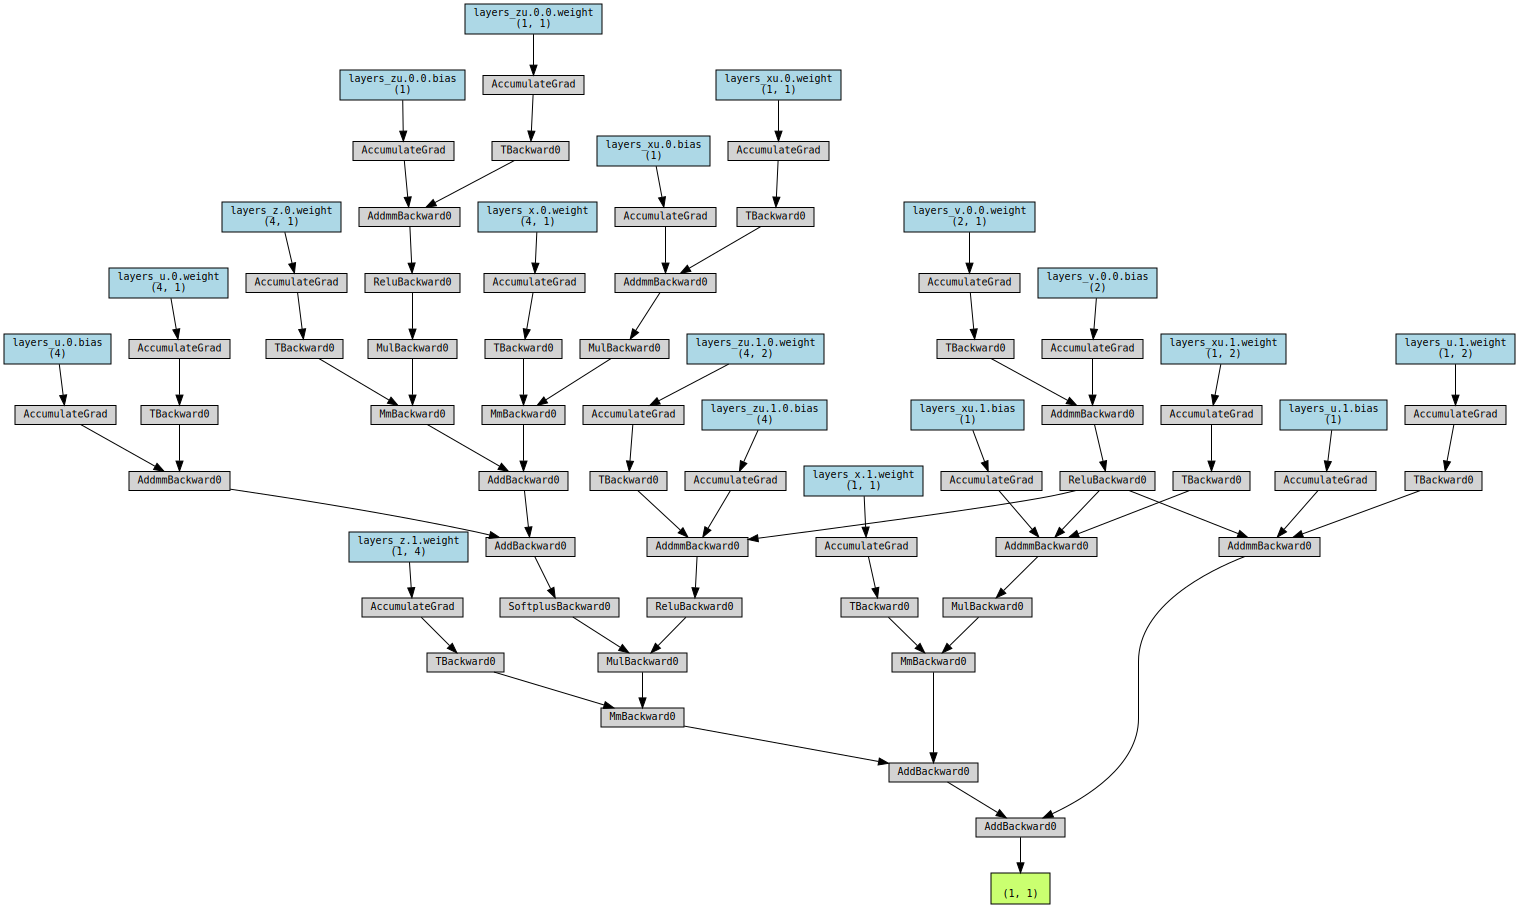

In [7]:
model = ICNNet()

x_test = torch.randn(1, 1) 
c_test = torch.randn(1, 1) 

output=model(x_test, c_test)
make_dot(output, params=dict(model.named_parameters()))

In [19]:
from torch import optim
epochs = 50

# Initialize the model
model = ICNNet()
model.train()

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs):
    for x_batch, c_batch, y_batch in dataloader:
        x_batch.requires_grad_(True)
        c_batch.requires_grad_(True)

        optimizer.zero_grad() # Zero the gradients
        
        output = model(x_batch, c_batch)  # Assuming context c is same as input x

        loss = criterion(output, y_batch) # Compute the loss
        loss.backward() # Backward pass

        optimizer.step() # Update the parameters
        # for layers_k in model.layers_z:
        #     for param in layers_k.parameters():
        #         param.data.clamp_min_(0)
        
        #pass

    #for name, parameter in model.named_parameters():
        #if parameter.requires_grad and parameter.grad is not None:
            #grad_norm = parameter.grad.norm().item()
            #print(f"Gradient norm for {name}: {grad_norm}")

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")




Epoch 1/50 Loss: 1.3739162683486938
Epoch 2/50 Loss: 0.31037595868110657
Epoch 3/50 Loss: 0.20516857504844666
Epoch 4/50 Loss: 0.08389683067798615
Epoch 5/50 Loss: 0.03348037600517273
Epoch 6/50 Loss: 0.006038554944097996
Epoch 7/50 Loss: 0.0011677161091938615
Epoch 8/50 Loss: 0.000751446932554245
Epoch 9/50 Loss: 0.00028177621425129473
Epoch 10/50 Loss: 0.0004157301445957273
Epoch 11/50 Loss: 0.0002666631480678916
Epoch 12/50 Loss: 0.00011570956849027425
Epoch 13/50 Loss: 0.00012179037730675191
Epoch 14/50 Loss: 7.964200631249696e-05
Epoch 15/50 Loss: 0.00013919359480496496
Epoch 16/50 Loss: 7.944490062072873e-05
Epoch 17/50 Loss: 3.894404289894737e-05
Epoch 18/50 Loss: 9.788035094970837e-05
Epoch 19/50 Loss: 6.123226194176823e-05
Epoch 20/50 Loss: 3.3913580409716815e-05
Epoch 21/50 Loss: 7.402823393931612e-05
Epoch 22/50 Loss: 1.5262265151250176e-05
Epoch 23/50 Loss: 3.7757203244837e-05
Epoch 24/50 Loss: 4.577189974952489e-05
Epoch 25/50 Loss: 3.75322561012581e-05
Epoch 26/50 Loss: 2

In [10]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for x_batch, c_batch, y_batch in dataloader:
        outputs = model(x_batch, c_batch)
        for result, y in zip(outputs, y_batch) :
            print(result, y)
        break



tensor([1.2705]) tensor([1.2687])
tensor([-0.1980]) tensor([-0.1972])
tensor([0.6785]) tensor([0.6776])
tensor([0.5533]) tensor([0.5526])
tensor([2.3143]) tensor([2.3121])
tensor([-0.2958]) tensor([-0.2950])
tensor([1.6556]) tensor([1.6534])
tensor([1.2349]) tensor([1.2331])
tensor([-0.5652]) tensor([-0.5640])
tensor([-1.3465]) tensor([-1.3450])
tensor([-0.0235]) tensor([-0.0231])
tensor([0.4200]) tensor([0.4197])
tensor([-1.6389]) tensor([-1.6371])
tensor([1.1517]) tensor([1.1501])
tensor([2.6860]) tensor([2.6841])
tensor([-1.1143]) tensor([-1.1129])
tensor([-0.6225]) tensor([-0.6214])
tensor([3.4018]) tensor([3.4019])
tensor([1.4743]) tensor([1.4723])
tensor([0.7831]) tensor([0.7820])
tensor([-0.4368]) tensor([-0.4358])
tensor([0.0791]) tensor([0.0795])
tensor([1.3437]) tensor([1.3418])
tensor([-1.5408]) tensor([-1.5391])
tensor([-1.0742]) tensor([-1.0729])
tensor([0.5146]) tensor([0.5140])
tensor([1.2700]) tensor([1.2682])
tensor([1.0778]) tensor([1.0763])
tensor([-1.4688]) tensor([

__Makkuva training__

In [21]:
from torch import optim
epochs = 100
train_freq_f = 3

# Initialize the model
input_size = 1
ICNNf = ICNNet(layer_sizes = [input_size, 2,2,2,2,1], context_layer_sizes=[1,2,2,2,2,2])

output_size = 1
ICNNg = ICNNet(layer_sizes = [output_size, 2,2,2,2,1], context_layer_sizes=[1,2,2,2,2,2])

# Define the loss function and the optimizer
optimizer_f = optim.Adam(ICNNf.parameters())
optimizer_g = optim.Adam(ICNNg.parameters())

for epoch in range(epochs):
    optimizer_f.zero_grad() # Zero the gradients
    optimizer_g.zero_grad() # Zero the gradients
    for _ in range(train_freq_f) :
        for x, c, y in dataloader:
            x.requires_grad_(True)
            y.requires_grad_(True)
            c.requires_grad_(True)

            output_g = ICNNg(y, c)
            diff_output_g = torch.autograd.grad(outputs=output_g, inputs=y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

            loss_f = - ICNNg(x, c) + ICNNf(diff_output_g, c)
            loss_f = torch.mean(loss_f)

            loss_f.backward() # Backward pass
            optimizer_f.step() # Update the parameters

            #for layers_k in ICNNf.layers_z:
                #for param in layers_k.parameters():
                    #param.data.clamp_min_(0)
            
            pass

    for x, c, y in dataloader:
        x.requires_grad_(True)
        y.requires_grad_(True)
        c.requires_grad_(True)
        
        output_g = ICNNg(y, c)
        diff_output_g = torch.autograd.grad(output_g, y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]
        
        loss_g = -torch.matmul(y.transpose(0,1), diff_output_g) - ICNNf(diff_output_g, c)

        loss_g = torch.mean(loss_g)
        loss_g.backward() # Backward pass

        optimizer_f.step() # Update the parameters
        for layers_k in ICNNf.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)

        optimizer_g.step() # Update the parameters
        for layers_k in ICNNg.layers_z:
            for param in layers_k.parameters():
                param.data.clamp_min_(0)

        #testing algorithm
        output_g_test = ICNNg(x, c)
        diff_output_g_test = torch.autograd.grad(output_g_test, x, grad_outputs=torch.ones_like(output_g_test), create_graph=True)[0]

        loss_test = diff_output_g_test-y

        #print('y =', y[0], 'diff_output_g =', diff_output_g_test[0])
        
        pass

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss_g.item()}")

Epoch 1/100 Loss: 0.3839559555053711
Epoch 2/100 Loss: 0.06670103222131729
Epoch 3/100 Loss: 0.0023313923738896847
Epoch 4/100 Loss: 2.565432548522949
Epoch 5/100 Loss: -2.6935555934906006
Epoch 6/100 Loss: -0.5884580612182617
Epoch 7/100 Loss: -0.7193419933319092
Epoch 8/100 Loss: -3.793898820877075
Epoch 9/100 Loss: -2.599432945251465
Epoch 10/100 Loss: 0.3782989978790283
Epoch 11/100 Loss: -5.789953708648682
Epoch 12/100 Loss: 0.9432947039604187
Epoch 13/100 Loss: -3.498218297958374
Epoch 14/100 Loss: 4.927997589111328
Epoch 15/100 Loss: -22.99002456665039
Epoch 16/100 Loss: 19.73575210571289
Epoch 17/100 Loss: -13.6056489944458
Epoch 18/100 Loss: -9.372962951660156
Epoch 19/100 Loss: -8.51181411743164
Epoch 20/100 Loss: 22.694780349731445
Epoch 21/100 Loss: -29.986045837402344
Epoch 22/100 Loss: 2.8632149696350098
Epoch 23/100 Loss: 26.672561645507812
Epoch 24/100 Loss: -70.63851165771484
Epoch 25/100 Loss: -215.3641815185547
Epoch 26/100 Loss: -91.8232650756836
Epoch 27/100 Loss: 

KeyboardInterrupt: 